In [ ]:
import argparse
import torch
import sys
import time
import os
import logging
import yaml
import shutil
import numpy as np
import torch.optim as optim
import torchvision
import matplotlib
import itertools
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import math
matplotlib.use('Agg')
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

This model is designed specifically for MNIST so I hardcoded most consitions. a test example is used to do preliminary test for different classes. Start with globle attention to get a useable model.

In [ ]:
image_size = 8
channels = 1

transform = transforms.Compose([
        #transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

dataset = datasets.MNIST('datasets/transformer', transform=transform, download=True)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=1)
input_dim = image_size ** 2 * channels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/transformer/MNIST/raw/train-images-idx3-ubyte.gz to datasets/transformer/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/transformer/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/transformer/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/transformer/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/transformer/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/transformer/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/transformer/MNIST/raw



# All function used to construct model

In [ ]:
def scaled_dot_product(q, k, v, attn_drop_rate=0.1, masked = False):
    d_k =  k.shape[-1]
    attn_logits = torch.matmul(q, torch.transpose(k, -2, -1))/d_k
    mask_base = torch.ones(attn_logits.shape)
    mask =  torch.triu(mask_base, diagonal=q.shape[-2]+1) # used for mask in training
    if masked:
        attn_logits = attn_logits.masked_fill_(mask.type(torch.BoolTensor).to(device) , -1e10)
    # compute softmax((QK^T)/d_k). Normalize attention weights to sum to 1 with a softmax over the key dimension.
    sf = torch.nn.Softmax(-1)
    attention = sf(attn_logits)
    # Add dropout to attention weights w/ attn_drop_rate.
    m = nn.Dropout(p=attn_drop_rate)
    attention = m(attention)
    # compute softmax((QK^T)/d_k)V.
    values = attention@v
    
    return values, attention

In [ ]:
bs = 1
num_heads = 1
seq_len, d_k = 3, 1
q = torch.randn(bs, num_heads, seq_len, d_k).to(device)
k = torch.randn(bs, num_heads, 6, d_k).to(device)
v = torch.randn(bs, num_heads, 6, d_k).to(device)
mask = torch.bernoulli(0.5 * torch.ones(bs, seq_len))
values, attention = scaled_dot_product(q, k, v, 0.0, True)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Mask\n", mask)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[[[ 2.8895],
          [-0.0756],
          [-0.1803]]]], device='cuda:0')
K
 tensor([[[[ 1.5203],
          [-0.4033],
          [-0.7490],
          [ 0.1705],
          [ 0.3024],
          [ 1.1621]]]], device='cuda:0')
V
 tensor([[[[ 0.1008],
          [ 0.9363],
          [-1.1681],
          [ 2.6354],
          [-0.6920],
          [ 1.3809]]]], device='cuda:0')
Mask
 tensor([[1., 1., 0.]])
Values
 tensor([[[[0.1522],
          [0.3527],
          [0.4847]]]], device='cuda:0')
Attention
 tensor([[[[0.9751, 0.0038, 0.0014, 0.0197, 0.0000, 0.0000],
          [0.1803, 0.2085, 0.2140, 0.1996, 0.1976, 0.0000],
          [0.1332, 0.1884, 0.2005, 0.1699, 0.1659, 0.1421]]]], device='cuda:0')


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, n_heads, attn_drop_rate, local1D = False):

    super().__init__()
    self.embed_dim = embed_dim
    self.n_heads = n_heads
    self.head_dim = embed_dim // n_heads
    self.attn_drop_rate = attn_drop_rate

    self.qkv_proj = nn.Linear(embed_dim, 3*embed_dim).to(device)

    self.o_proj =  nn.Linear(embed_dim, embed_dim)

    self._reset_parameters()
    self.local1D = local1D

  def _reset_parameters(self):

      nn.init.xavier_uniform_(self.qkv_proj.weight)
      self.qkv_proj.bias.data.fill_(0)
      nn.init.xavier_uniform_(self.o_proj.weight)
      self.o_proj.bias.data.fill_(0)
  
  def forward(self, embedding, masked):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #  get batch_size, seq_length, embed_dim.
    batch_size, seq_length, embed_dim = embedding.shape[0], embedding.shape[1], embedding.shape[2]
    #  Compute queries, keys, and values (keep continguous for now).
    qkv = self.qkv_proj(embedding)
    #  Separate Q, K, V from linear output, give each shape [batch, num_head, seq_len, head_dim] (may require transposing/permuting dimensions)
    qkv = torch.reshape(qkv, [batch_size, seq_length, self.n_heads, 3*self.head_dim])
    qkv = qkv.permute(0, 2, 1, 3)
    q, k, v = qkv.chunk(3, dim=-1)
    if self.local1D == True:
            len = seq_length
            blen = 256
            pad = (0, 0, 0, (-len) % blen) # Append to multiple of block length
            q = F.pad(q, pad)
            k = F.pad(k, pad)
            v = F.pad(v, pad)

            bias = -1e9 * torch.triu(torch.ones(blen, blen), 1).to(X.device)
            first_output, first_attention = self.dot_product_attention(
                q[:,:,:blen,:], k[:,:,:blen,:], v[:,:,:blen,:], masked = True)
            if q.shape[2] > blen:
                q = q.view(q.shape[0], q.shape[1], -1, blen, q.shape[3])
                k = k.view(k.shape[0], k.shape[1], -1, blen, k.shape[3])
                v = v.view(v.shape[0], v.shape[1], -1, blen, v.shape[3])
                local_k = torch.cat([k[:,:,:-1], k[:,:,1:]], 3) # [batch, nheads, (nblocks - 1), blen * 2, depth]
                local_v = torch.cat([v[:,:,:-1], v[:,:,1:]], 3)
                tail_q = q[:,:,1:]
                bias = -1e9 * torch.triu(torch.ones(blen, 2 * blen), blen + 1).to(X.device)
                tail_output, tail_attention = self.dot_product_attention(tail_q, local_k, local_v, masked = True)
                tail_output = tail_output.view(tail_output.shape[0], tail_output.shape[1], -1, tail_output.shape[4])
                result = torch.cat([first_output, tail_output], 2)
                result = result[:,:,:X.shape[1],:]
            else:
                result = first_output[:,:,:X.shape[1],:] #[batch, nheads, length, depth]
    else:
            result, attention = scaled_dot_product(q, k, v, masked=masked) 
    result = result.permute(0, 2, 1, 3)         #move attention head to last dimension 
    result = result.reshape(batch_size, seq_length, embed_dim) # concate attention head with the embeding dimension 
    #  Linearly project attention outputs w/ W^O.
    # The final dimensionality should match that of the inputs.
    attended_embeds = self.o_proj(result)
    
    return attended_embeds

In [ ]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))



class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim: int, drop_rate=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=drop_rate)
        position = torch.arange(max_len).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim)).to(device)
        pe = torch.zeros(1, max_len, embed_dim).to(device)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)     


class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(X + self.dropout(Y))
        
def get_lr(step, config):
    warmup_steps = config.optim.warmup
    lr_base = config.optim.lr * 0.002 # for Adam correction
    ret = 5000. * config.model.hidden_size ** (-0.5) * \
          np.min([(step + 1) * warmup_steps ** (-1.5), (step + 1) ** (-0.5)])
    return ret * lr_base
        

In [ ]:
class TransformerDecoderBlock(nn.Module):
  def __init__(self, embed_dim, n_heads, attn_drop_rate, layer_drop_rate, local1D = False):
    super().__init__()
    self.embed_dim = embed_dim
    self.n_heads = n_heads
    self.layer_dropout = nn.Dropout(layer_drop_rate)

    # efine attention layer
    self.self_attn = MultiHeadAttention(embed_dim, n_heads, attn_drop_rate, local1D)

    # positional feed forword: 
    self.linear_net = PositionWiseFFN(embed_dim, embed_dim, embed_dim)

  def forward(self, inputs, masked = False):
    embedding  = inputs
    # compute multi-head attention
    attn_out = self.self_attn(embedding, masked)

    addNorm = AddNorm([inputs.shape[1], self.embed_dim], 0.5).to(device)
    # add dropout
    outputs2 = addNorm(inputs, attn_out)

    X3 = addNorm(outputs2 ,self.linear_net(outputs2))
    return X3


    

# training with transformer model 

In [ ]:
# transformer = TransformerModel(512, 16, 0.5, 0.5, local1D=True)
# optimizer = optim.Adam(transformer.parameters(), lr=1., betas=(0.9, 0.98), eps=1e-9)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step)) #significant effect. I don't
# transformer.train()
# transformer = transformer.to(device)
for epoch in range(2): #4 has good result 
  i = 0
  losses = 0
  for num_batch, (X,k) in enumerate(tqdm(loader)):
    i = i + 1
    X = X.to(device)
    k = k.to(device).long()
    X = (X * (256 - 1)).long()
    X = X.view(X.shape[0], -1) 
    optimizer.zero_grad()
    pred = transformer(X, k)
    loss = F.cross_entropy(pred, X, reduction='none')
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses = losses + loss.item()
  torch.save({
            'epoch': epoch,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict':scheduler.state_dict(),
            'loss': loss,
            }, f'/content/drive/MyDrive/example/transformer_checkpoint_local1DNew{epoch}.pt')
  print(losses/i)


100%|██████████| 3750/3750 [1:26:20<00:00,  1.38s/it]


0.7765510438481966


  2%|▏         | 63/3750 [01:29<1:26:51,  1.41s/it]


KeyboardInterrupt: ignored

In [ ]:
transformer = TransformerModel(512, 16, 0.5, 0.5, local1D=True).to(device)
optimizer = optim.Adam(transformer.parameters(), lr=1., betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step))
checkpoint = torch.load('/content/drive/MyDrive/example/transformer_checkpoint_local1DNew0.pt')
transformer.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
for num_batch, (X,k) in enumerate(loader):
  break

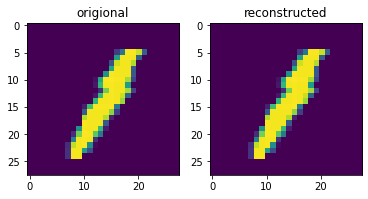

In [ ]:
target = (X[1:4] * (256 - 1)).long()
target = target.view(target.shape[0], -1) 
target = target.to(device)

num = k[1:4].long().to(device)
num = num.to(device)
transformer.eval()
pred = transformer(target, num)

imagesize = int(math.sqrt(pred.shape[-1]))

plt.subplot(1,2,1)
plt.title('origional')
plt.imshow(target[0].view(imagesize,imagesize).cpu())
plt.subplot(1,2,2)
plt.title('reconstructed')
plt.imshow(pred[0].argmax(0).view(imagesize,imagesize).cpu())

100%|██████████| 783/783 [03:09<00:00,  4.14it/s]


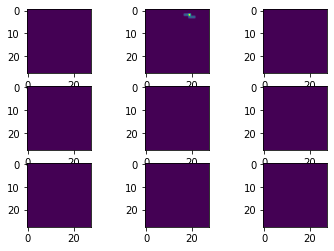

In [ ]:
with torch.no_grad():  
  transformer.eval()  
  sample = torch.zeros(9,1).long().to(device)
  k =  0*torch.ones(9).long().to(device)
  sm = nn.Softmax(1)
  for j in tqdm(range(783)):
    pred = transformer(sample, k, sampling = True)
    predv = pred[:,:,-1]
    prob, t20_items = torch.topk(predv, 20, dim = 1)
    smprob = sm(prob)
    prob_dist = torch.distributions.Categorical(smprob)
    index = prob_dist.sample()
    sample = torch.cat((sample, t20_items[torch.arange(len(t20_items)),index][:,None]), dim = -1) 
  imagesize = int(math.sqrt(sample.shape[-1]))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(sample[i-1].view(imagesize,imagesize).to('cpu').numpy())